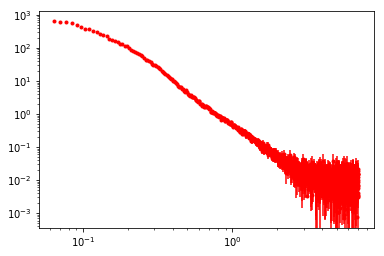

Figure 1: data


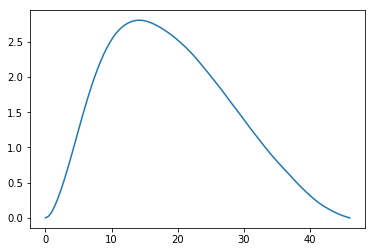

Figure 2: Pair distance distribution function prM.


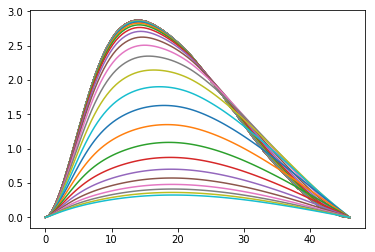

Figure 3: all distributions.


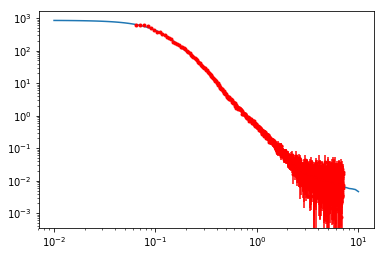

Figure 4: Data (red points) and fit (blue line).


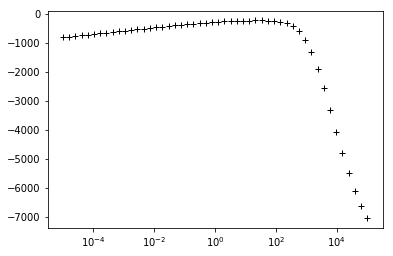

Figure 5: evidence vs alpha.


In [2]:
# In this notebook the pair distance distribution function is extracted from 
# the small-angle scatering data (here SAXS, but could be also SANS) of a nanoparticle sample
# by a regularized numerical inversion (i.e., an indirect Fourier transform IFT).
# The results are published in: 
# "Influence of clustering on the magnetic properties and hyperthermia performance of iron oxide nanoparticles"
# https://doi.org/10.1088/1361-6528/aad67d

#==============================================================================
# import of used packages
from numpy.linalg import slogdet
import numpy as np
import pylab as py
from scipy.optimize import nnls, lsq_linear
#==============================================================================
# import of data

q,Iq,sd=np.genfromtxt("../data/FSL-SAXS_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2))
  
qfit=np.logspace(-2,1,100)

Nq=len(q)

N=100 # N is number of r values in determined pair distance distribution function

#==============================================================================
# generate list for regularization parameter a and diameter D

ND=51
DList=np.linspace(10,110,ND) # Diameter list

Na=50
aList=np.logspace(-5,5,Na) # regularization parameter

#==============================================================================
# Plot data

py.errorbar(q,Iq,sd,color='r',marker='.',ls='None',label='Observed')
py.xscale('log')
py.yscale('log')
py.show()
print('Figure 1: data')   

#==============================================================================
# regularization matrices

L=0.5*(-1*np.eye(N,k=-1)+2*np.eye(N,k=0)-1*np.eye(N,k=1))
L[0,1] = 0
L[N-1,N-2] = 0

#==============================================================================
# Definition of function to generate the system matrix

def Aij(q,r,dr): # IFT
    y=4*np.pi*np.sin(q*r)/(q*r)*dr 
    return y

def trans(q,r,dr): # function to generate the transfer matrix
    A=[]
    for j in range(len(q)):
        A.append([Aij(r[i],q[j],dr[i]) for i in range(len(r))])
    return A 

#==============================================================================
# Inversion of data (for varying D and a values the data is inversed, evidence determined)
evList1=[] 
evList=[] 
prList=[]

for Di in range(len(DList)):   
    
    # defintion of r-List   
    r=np.linspace(0,DList[Di],N)
    dr=[]
    for j in range(len(r)):
        dr.append((r[1]-r[0]))
    r[0]=+1.e-15
              
    K=trans(q,r,dr) 
    K=np.asarray(K)
    
    for ai in range(len(aList)):                         
        sd_sq   = pow(sd,2)       
        sdnorm  = 1/sd 
        sdnorm = Nq * sdnorm/sdnorm.sum()
        sdmat = np.diag(sdnorm)
        sdcol  = sdnorm[:,np.newaxis]            

        I = Iq.dot(sdmat) # normalize data by sigma
        I2 = Iq
        
       # stacking of matrices            
        C = np.vstack([K*sdcol,np.sqrt(aList[ai])*L]) 
        X = np.hstack([I, np.zeros(N)]) 
        B = (K.T).dot(K*pow(sdcol,2))            
        
        # Fit: 
#        sol1, resnorm = nnls(C,X) # least-square fit with non-negative constraint
        sol2=np.dot(np.dot(np.linalg.inv(np.dot(C.T,C)),C.T),X) # Least-square fit without non-negative constraint

        pr = sol2 
        
        # determine chisquare            
        Ifit=K.dot(pr)    
        chisq=(pow(I2-Ifit,2)/sd_sq).sum()               

        # calculation of evidence 
        S=sum(pow(L.dot(pr),2))
        Lsq=pow(L,2)                   
        U=2*Lsq+B/aList[ai] 
        detsign,rlogdet=slogdet(U)
        G=-aList[ai]*S-0.5*chisq        
        evidence=(G-0.5*rlogdet) # log of evidence
            
        evList1.append(np.hstack([aList[ai],DList[Di],evidence]))
        
        evList.append(evidence)            
        prList.append(pr) 

# Search for maximal Diameter with highest evidence
MAX=evList.index(max(evList))

evList1=np.asarray(evList1)
DM=evList1[MAX,1]
prM=prList[MAX]

# maximal diameter is fixed to DM
# r-List is constructed for DM and pr's for all alpha values written in new list
# as well as corresponding evidence values
rM=np.linspace(0,DM,N)
drM=[]
for j in range(len(rM)):
    drM.append((rM[1]-rM[0]))
rM[0]=+1.e-15

prList2=[]
for i in range(ND*Na):
    if evList1[i,1]==DM:
        prList2.append(prList[i])
prList22=np.reshape(prList2,(Na,N))

evList22=[]
for i in range(ND*Na):
    if evList1[i,1]==DM:
        evList22.append(evList[i])
#==============================================================================
# Reconstruction of I(q)
        
KM=trans(qfit,rM,drM) 
KM=np.asarray(KM)

IfitM=KM.dot(prM)

#==============================================================================
# Plots

py.plot(rM,prM)
py.show()   
print('Figure 2: Pair distance distribution function prM.')

py.figure()
for i in range(Na):
    py.plot(rM,prList22[i,:])
py.show() 
print('Figure 3: all distributions.')

py.errorbar(q,Iq,sd,color='r',marker='.',ls='None',label='Observed')
py.loglog(qfit,IfitM)
py.show() 
print('Figure 4: Data (red points) and fit (blue line).')

py.plot(aList,evList22,'k+')
py.xscale('log')
py.show()
print('Figure 5: evidence vs alpha.')